In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # For cleaning filenames for titles

------------------------------------------------------------
To install it, run: !pip install adjustText  (in a Jupyter cell)
or: pip install adjustText (in your terminal)
------------------------------------------------------------

Processing file: type 8 cone bipolar cell (sensu Mus)_vs_rest.csv


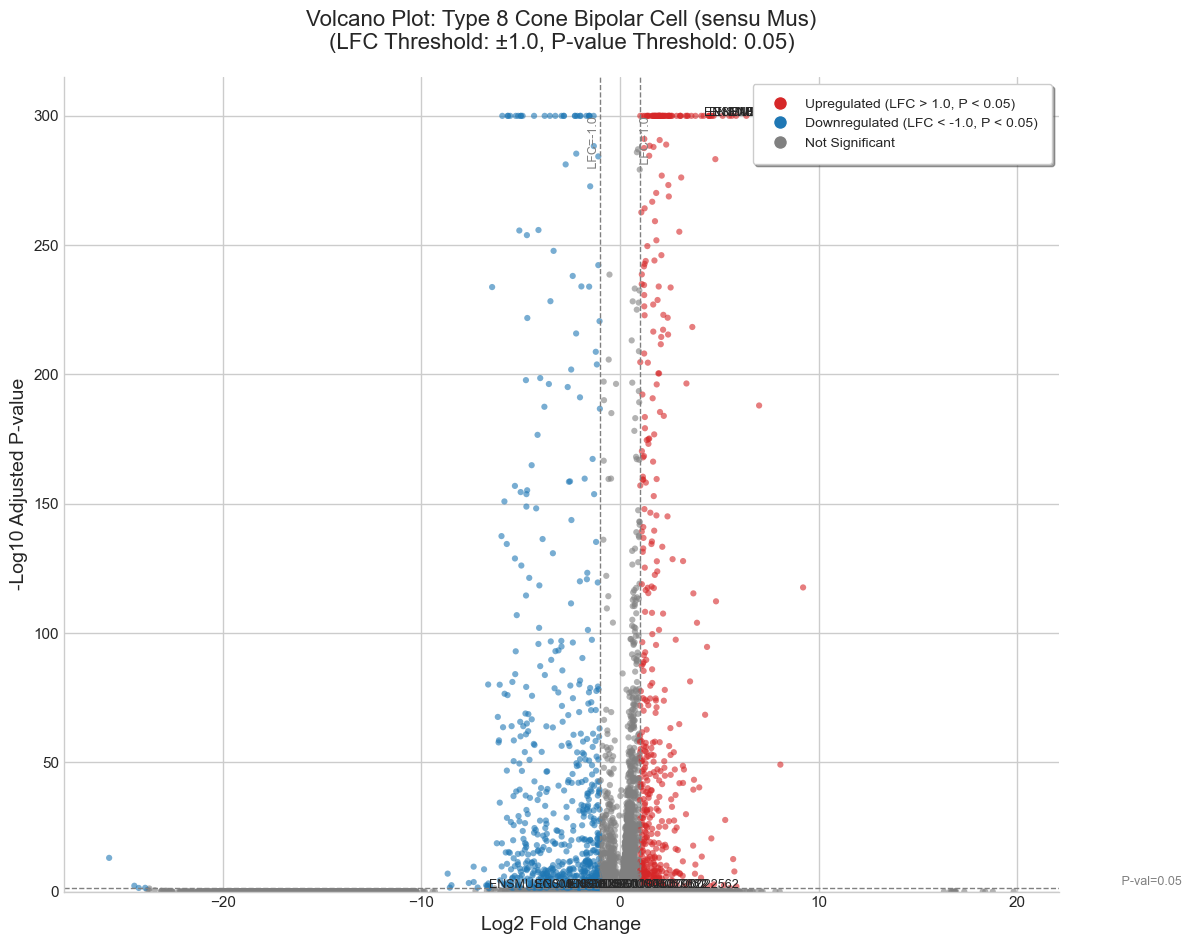


Processing file: type 5a cone bipolar cell_vs_rest.csv


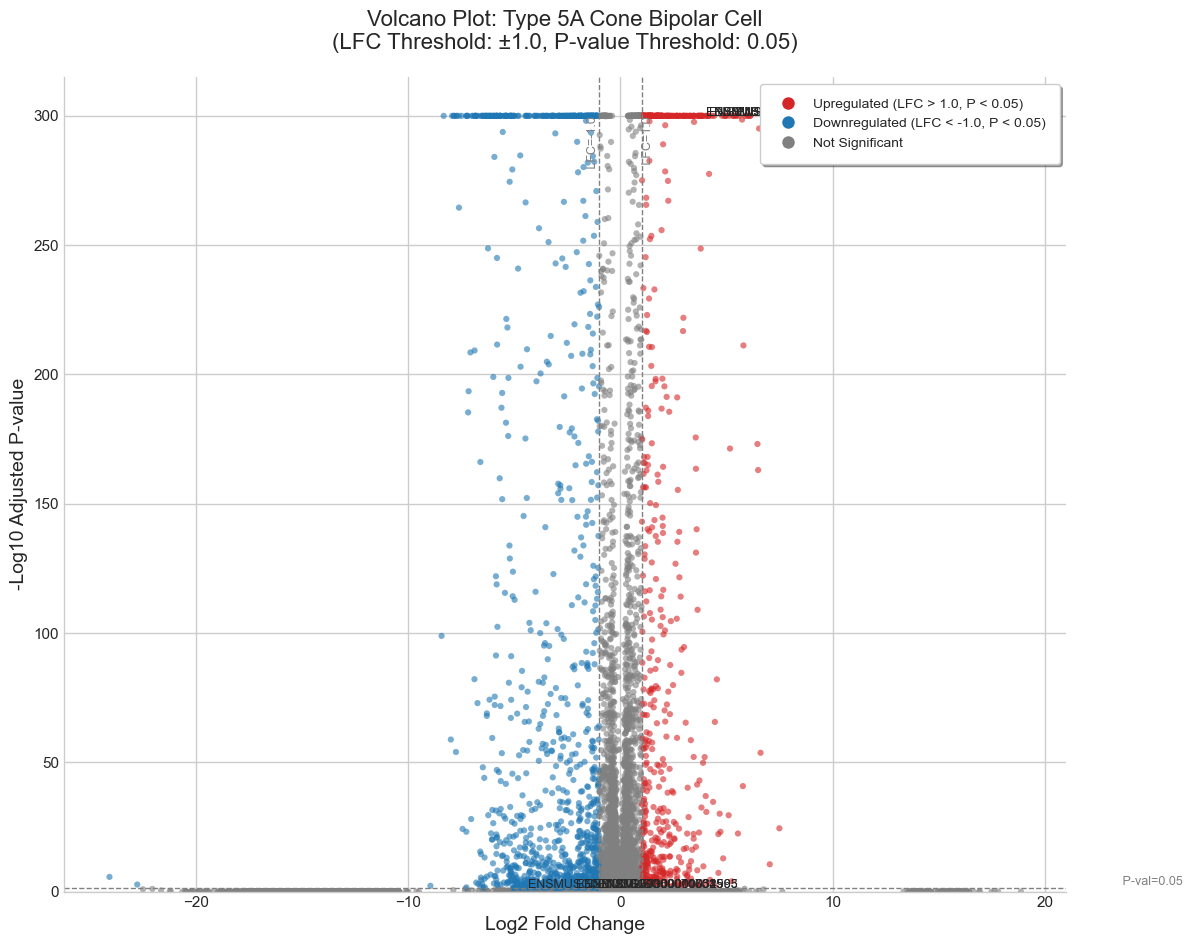


Processing file: type 3a cone bipolar cell_vs_rest.csv


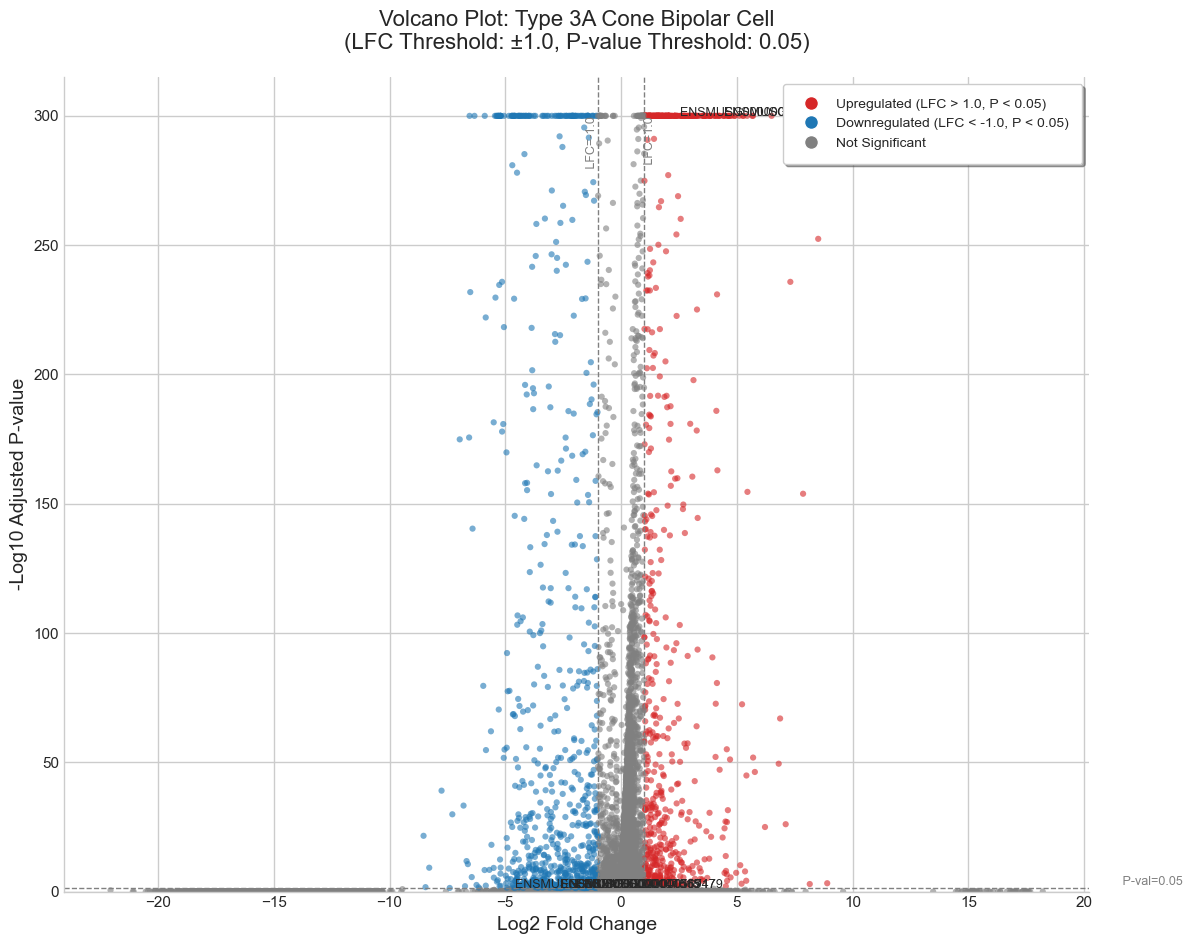


Processing file: type 9 cone bipolar cell (sensu Mus)_vs_rest.csv


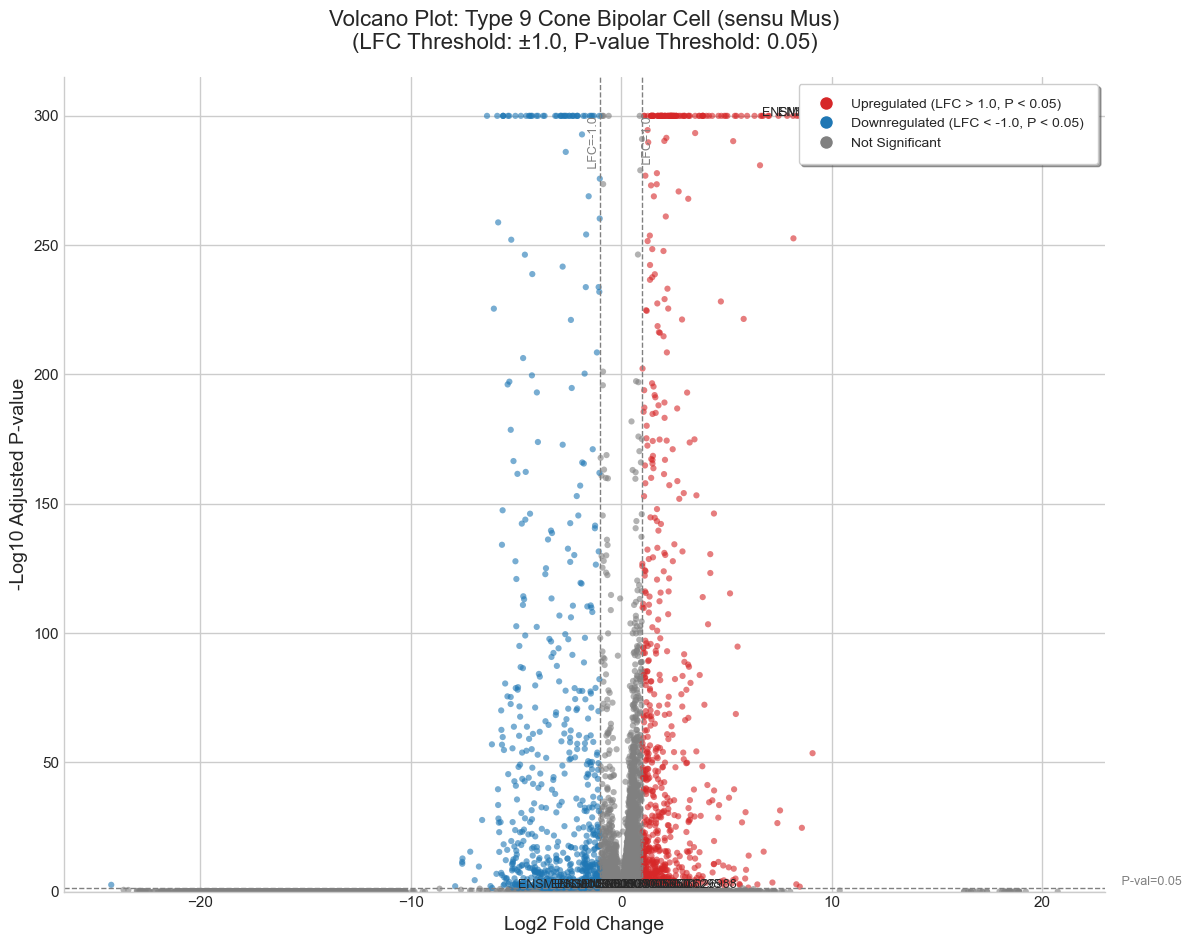


Processing file: type 1 cone bipolar cell (sensu Mus)_vs_rest.csv


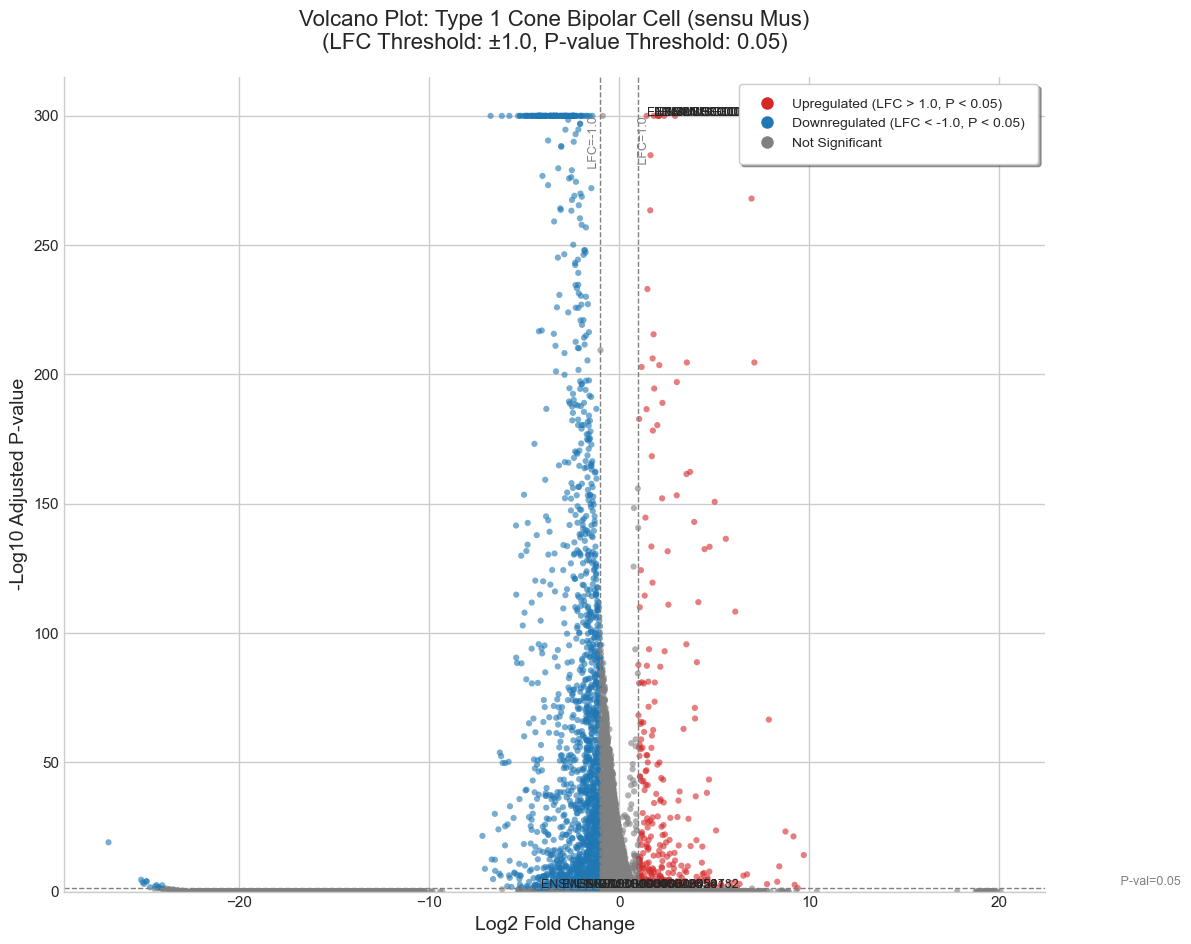


Processing file: type 7 cone bipolar cell (sensu Mus)_vs_rest.csv


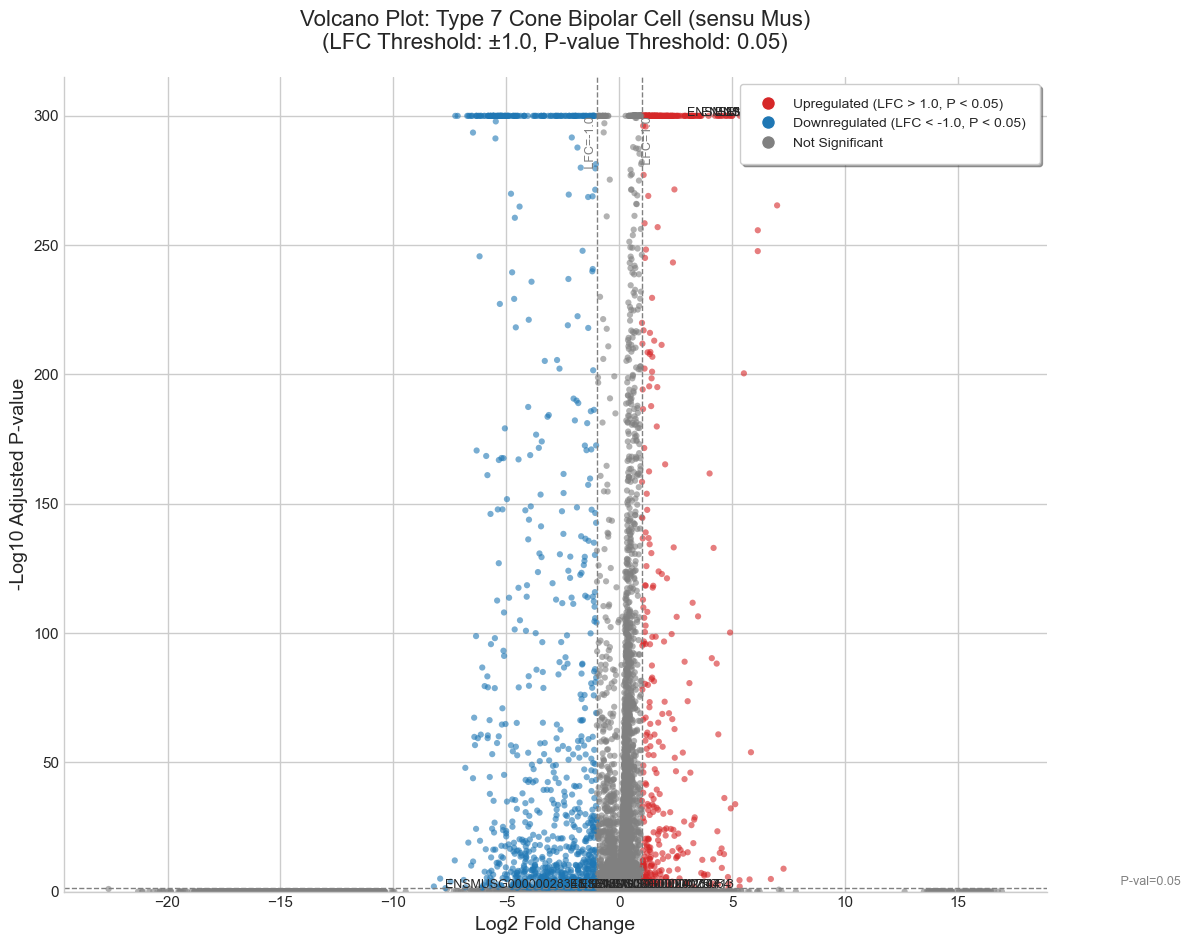


Processing file: type 6 cone bipolar cell (sensu Mus)_vs_rest.csv


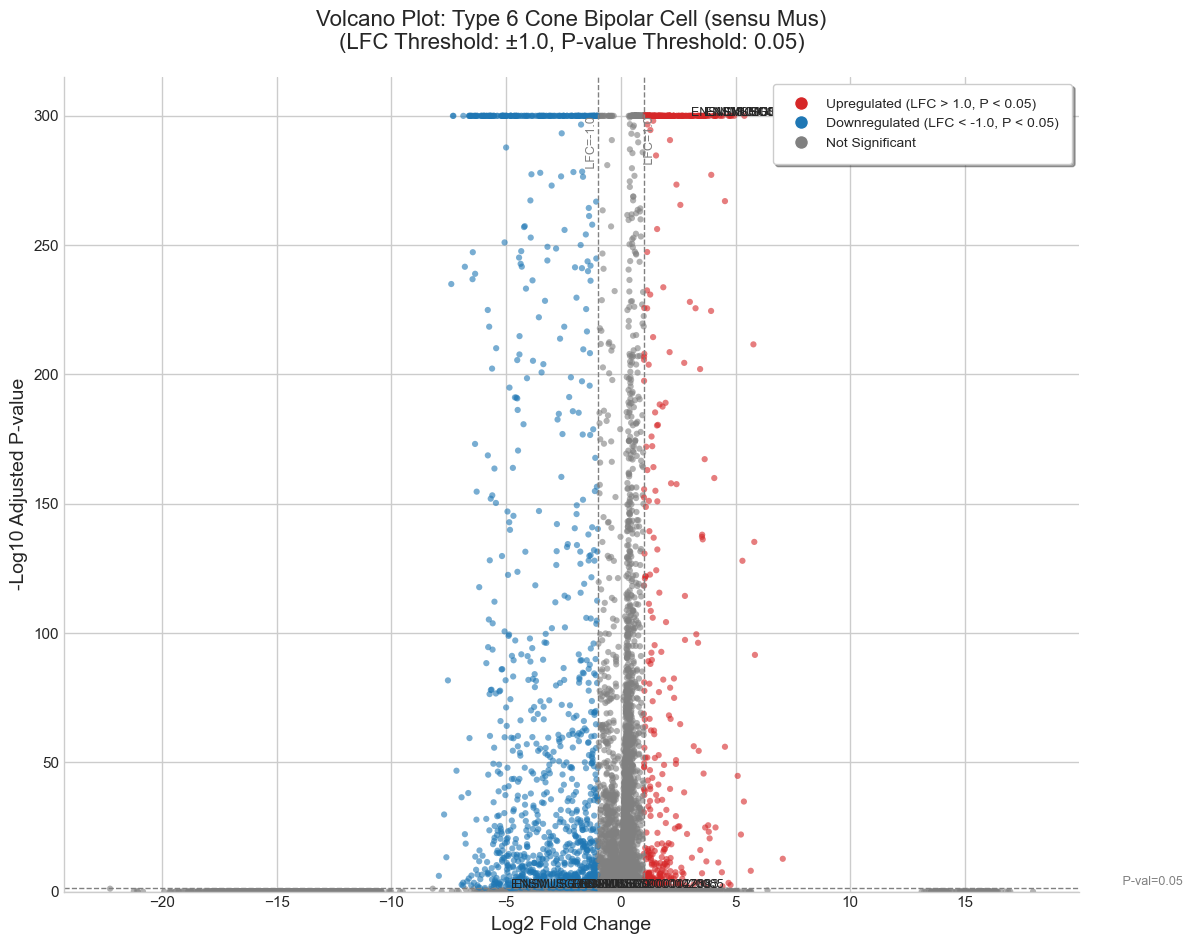


Processing file: type 2 cone bipolar cell (sensu Mus)_vs_rest.csv


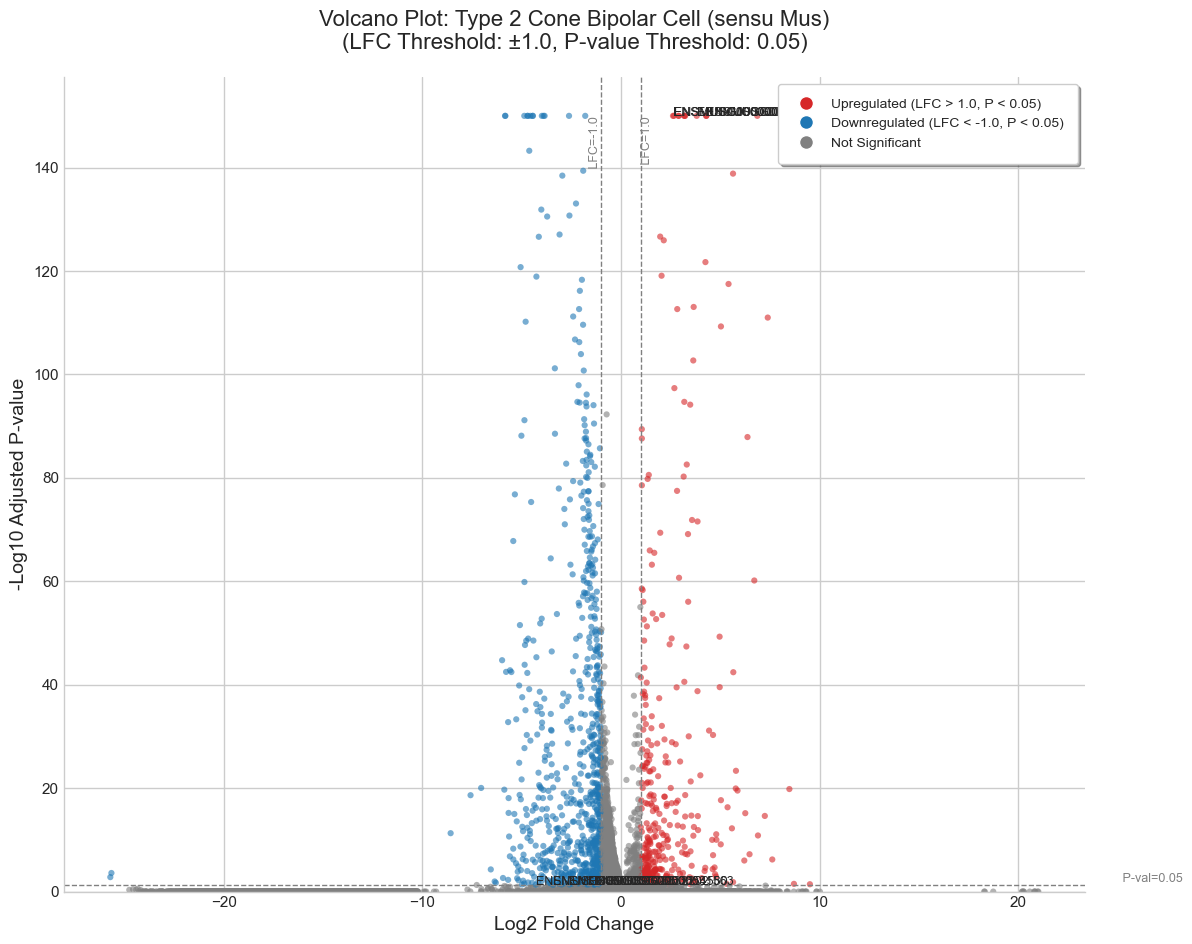


Processing file: type 5b cone bipolar cell_vs_rest.csv


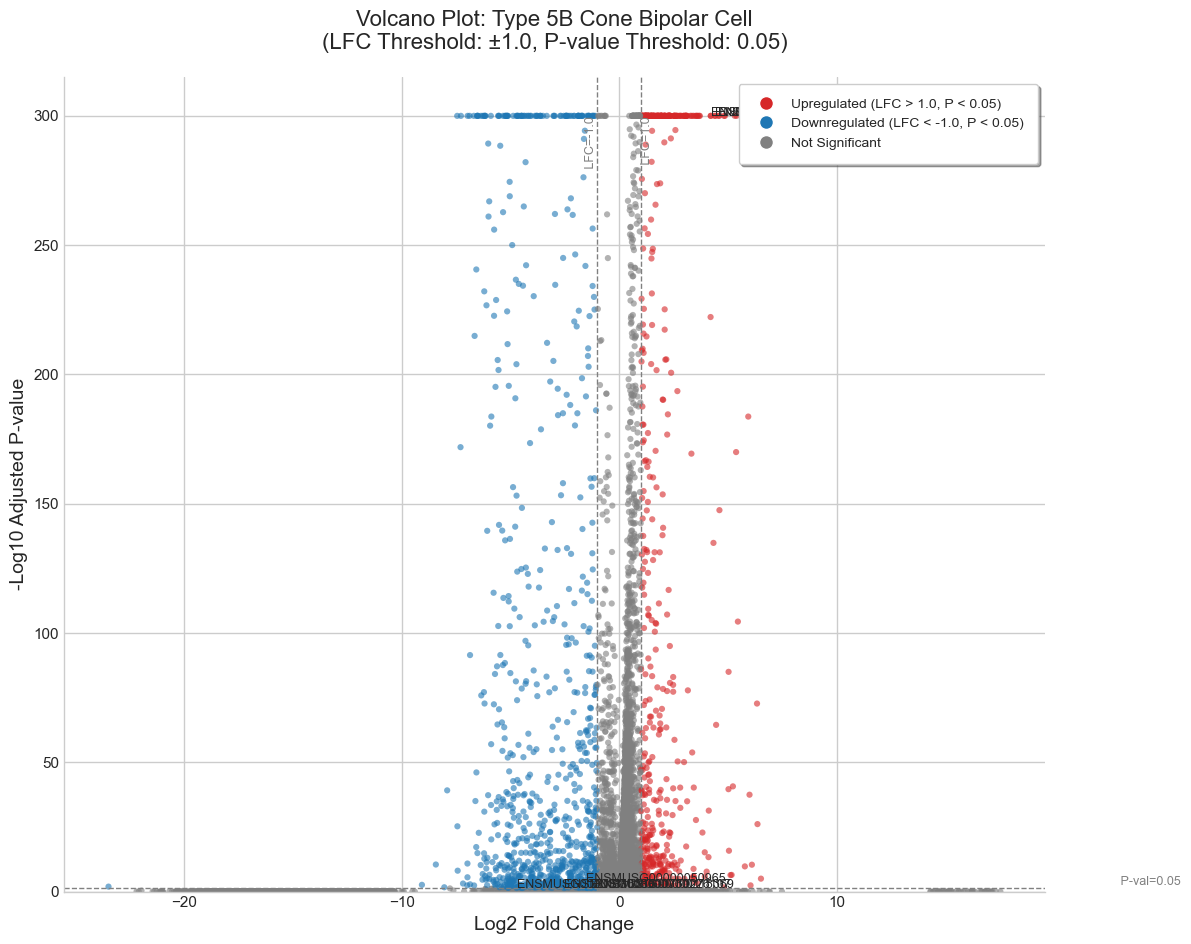


Processing file: type 3b cone bipolar cell_vs_rest.csv


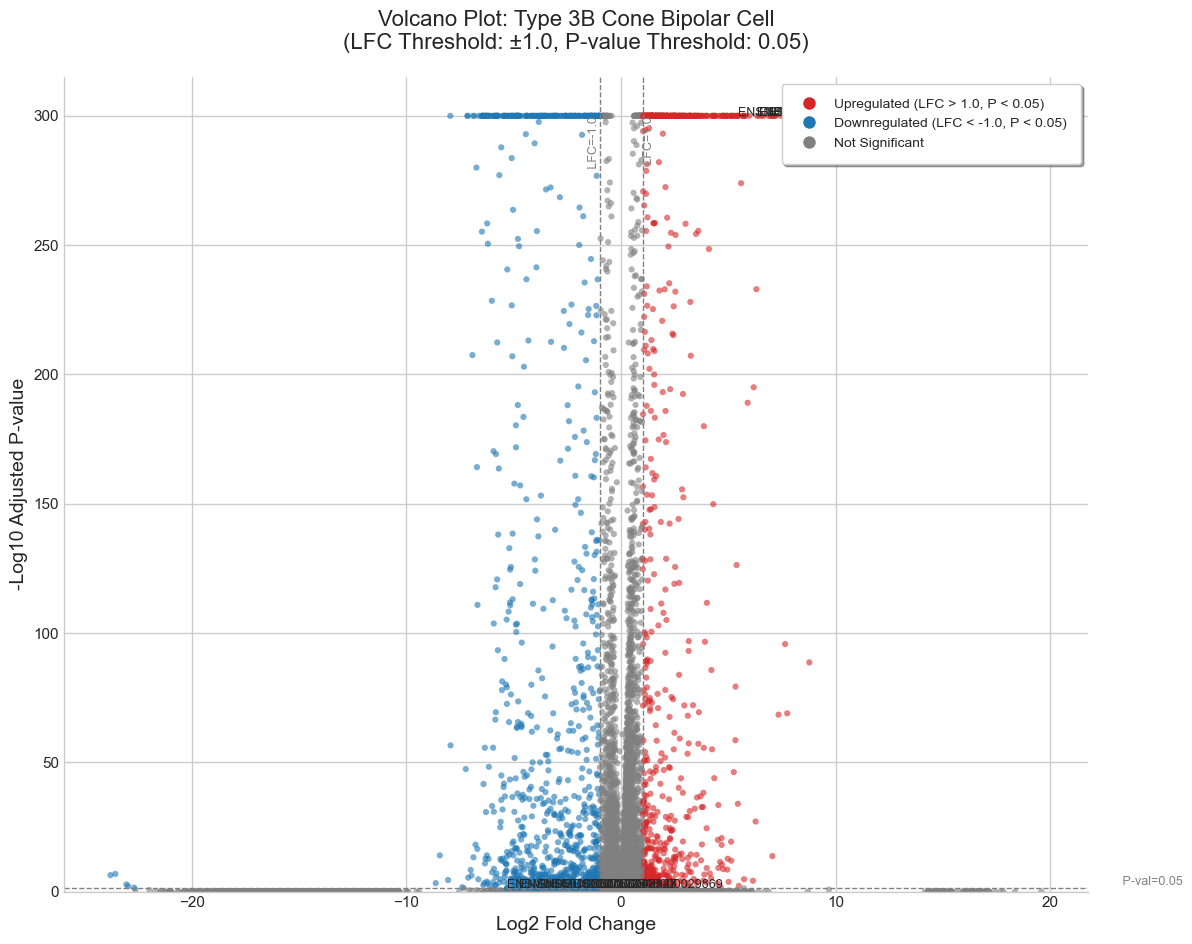


Processing file: rod bipolar cell_vs_rest.csv


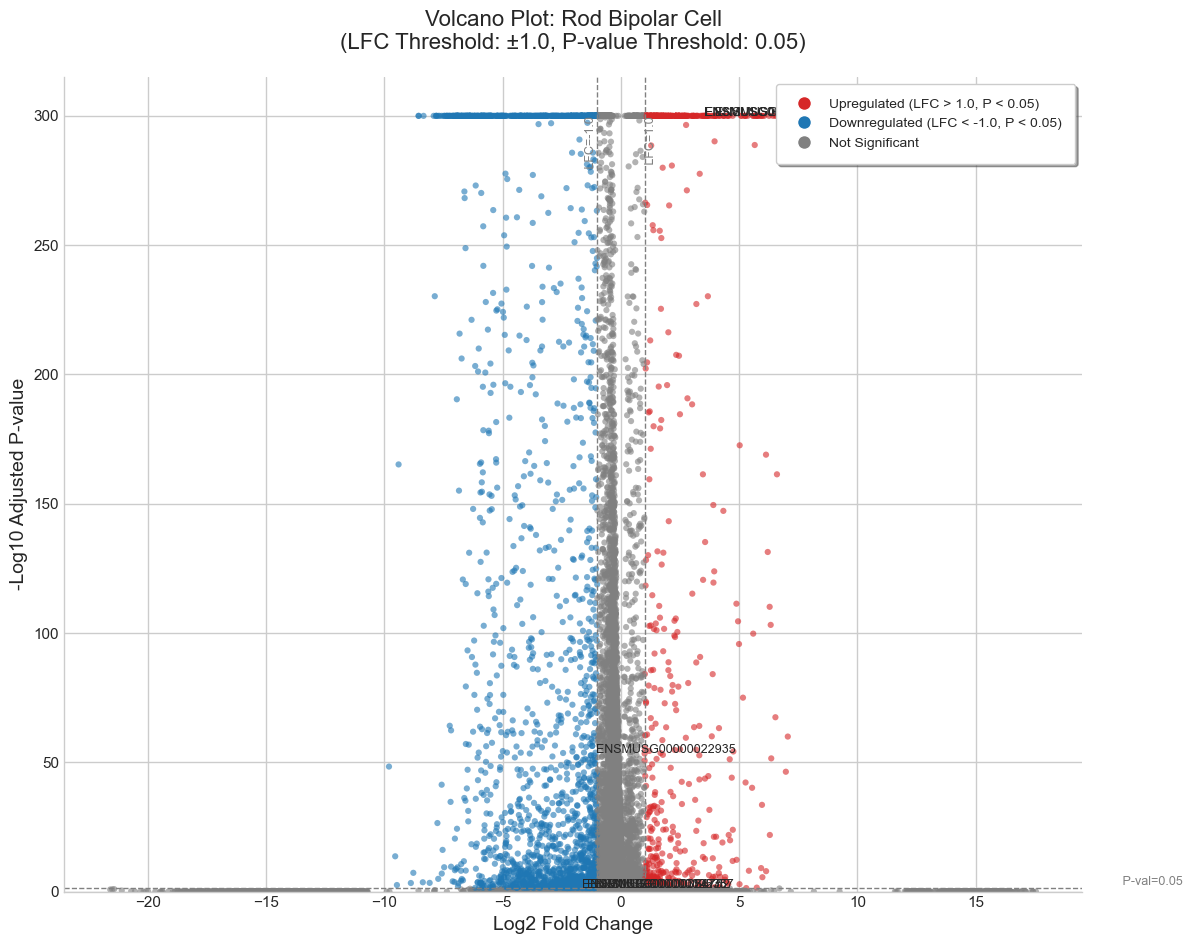


Processing file: type 5 cone bipolar cell (sensu Mus)_vs_rest.csv


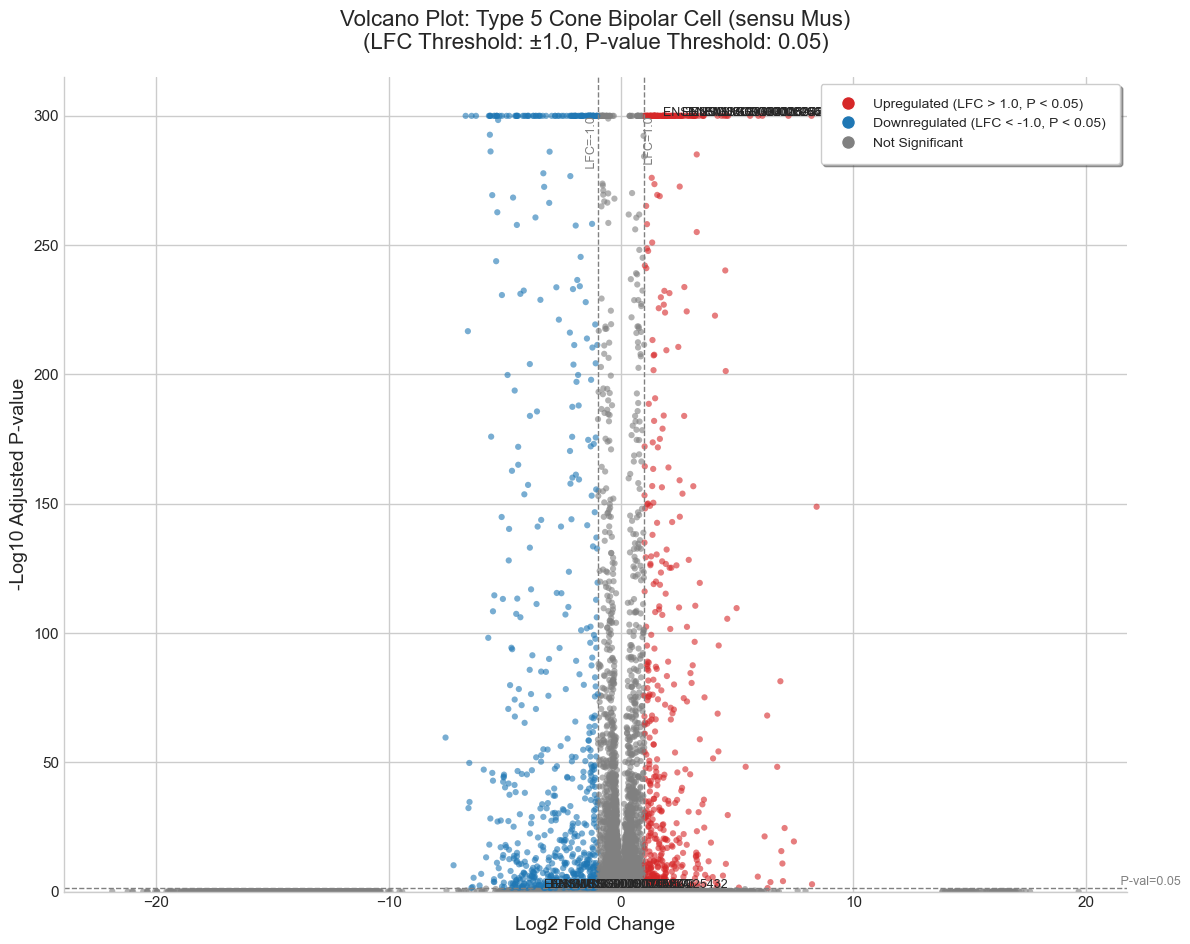


Processing file: type 4 cone bipolar cell (sensu Mus)_vs_rest.csv


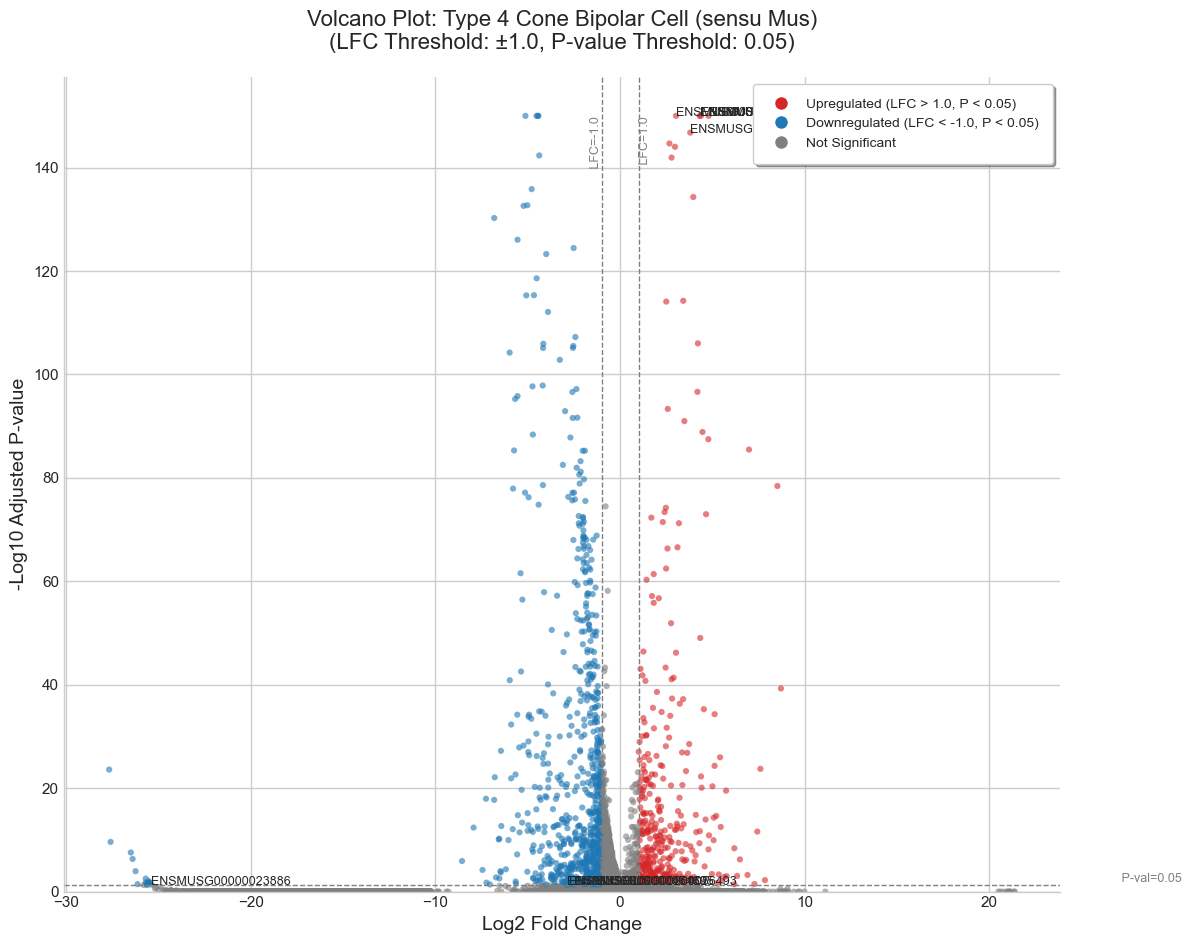


Volcano plot generation complete. 13 plots displayed.


In [5]:
# --- Configuration ---
INPUT_DIR = "../results/dea_results/"
# OUTPUT_DIR is removed as plots will be displayed inline
# Thresholds for significance
LFC_THRESHOLD = 1.0  # Absolute Log2 Fold Change threshold
PVAL_THRESHOLD = 0.05 # Adjusted P-value threshold
# Number of top genes to label on each side (up/down)
NUM_TOP_GENES_TO_LABEL = 5
# Minimum p-value to use if original is 0, to avoid log(0) error
MIN_P_VAL = 1e-300

# --- Helper function to create output directory (No longer needed for file output) ---
# def ensure_dir(directory):
#     """Creates the directory if it does not exist."""
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#         print(f"Created directory: {directory}")

# --- Main plotting function ---
def create_volcano_plot(df, title_base):
    """
    Generates and displays a volcano plot from the DataFrame in a Jupyter Notebook.

    Args:
        df (pd.DataFrame): DataFrame containing gene expression data.
                           Must include 'logfoldchange', and 'gene'.
                           Should include 'pval_adj' or 'pval'.
                           'score' column is used for ranking if present.
        title_base (str): Base string for the plot title.
    """
    # Make a copy to avoid modifying the original DataFrame
    df = df.copy()

    # --- 1. Data Preparation ---
    # Check for essential columns
    if 'logfoldchange' not in df.columns:
        print(f"Skipping plot for '{title_base}': 'logfoldchange' column missing.")
        return
    if 'gene' not in df.columns:
        print(f"Warning for '{title_base}': 'gene' column missing. Genes will not be labeled.")
        # Add a dummy gene column if missing
        df['gene'] = 'Unknown'


    # Determine which p-value column to use
    pval_col_name = ''
    if 'pval_adj' in df.columns and not df['pval_adj'].isnull().all() and df['pval_adj'].nunique() > 1 :
        pval_col_name = 'pval_adj'
        y_axis_label_suffix = 'Adjusted P-value'
    elif 'pval' in df.columns:
        pval_col_name = 'pval'
        y_axis_label_suffix = 'P-value'
        print(f"Warning for '{title_base}': Using 'pval' as 'pval_adj' is missing, all null, or has only one unique value.")
    else:
        print(f"Error for '{title_base}': Neither 'pval_adj' nor 'pval' found or suitable. Skipping plot.")
        return

    # Replace 0 p-values with a very small number to avoid log(0) issues
    # Also handle potential NaN values in p-value column by filling with 1 (not significant)
    df[pval_col_name] = df[pval_col_name].fillna(1.0).replace(0, MIN_P_VAL)
    df['-log10_pval'] = -np.log10(df[pval_col_name])

    # Cap -log10_pval if it's excessively high
    finite_log_pvals = df.loc[np.isfinite(df['-log10_pval']), '-log10_pval']
    if not finite_log_pvals.empty:
        cap_value = np.percentile(finite_log_pvals, 99.9) if len(finite_log_pvals) > 10 else finite_log_pvals.max()
        min_cap = -np.log10(PVAL_THRESHOLD) + 10
        cap_value = max(cap_value, min_cap, -np.log10(MIN_P_VAL)/2)
        df['-log10_pval'] = np.clip(df['-log10_pval'], 0, cap_value)
    else:
        df['-log10_pval'] = np.clip(df['-log10_pval'], 0, -np.log10(MIN_P_VAL))


    # --- 2. Classify Genes ---
    df['color'] = 'grey' # Default: Non-significant
    df['significant'] = False

    up_condition = (df['logfoldchange'] > LFC_THRESHOLD) & (df[pval_col_name] < PVAL_THRESHOLD)
    df.loc[up_condition, 'color'] = '#d62728' # Red
    df.loc[up_condition, 'significant'] = True

    down_condition = (df['logfoldchange'] < -LFC_THRESHOLD) & (df[pval_col_name] < PVAL_THRESHOLD)
    df.loc[down_condition, 'color'] = '#1f77b4' # Blue
    df.loc[down_condition, 'significant'] = True

    # --- 3. Create Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 10))

    plt.scatter(df['logfoldchange'], df['-log10_pval'],
                c=df['color'],
                alpha=0.6,
                s=20,
                edgecolors='none')

    plt.axhline(-np.log10(PVAL_THRESHOLD), linestyle='--', color='grey', linewidth=1)
    plt.axvline(LFC_THRESHOLD, linestyle='--', color='grey', linewidth=1)
    plt.axvline(-LFC_THRESHOLD, linestyle='--', color='grey', linewidth=1)

    max_x = df['logfoldchange'].abs().max() * 1.1 if not df['logfoldchange'].empty else LFC_THRESHOLD * 2
    max_y = df['-log10_pval'].max() if not df['-log10_pval'].empty else -np.log10(PVAL_THRESHOLD) * 2

    plt.text(max_x, -np.log10(PVAL_THRESHOLD), f' P-val={PVAL_THRESHOLD}',
             verticalalignment='bottom', horizontalalignment='right', color='grey', fontsize=9)
    plt.text(LFC_THRESHOLD, max_y if pd.notna(max_y) else 10, f' LFC={LFC_THRESHOLD}',
             verticalalignment='top', horizontalalignment='left', color='grey', fontsize=9, rotation=90)
    plt.text(-LFC_THRESHOLD, max_y if pd.notna(max_y) else 10, f' LFC=-{LFC_THRESHOLD}',
             verticalalignment='top', horizontalalignment='right', color='grey', fontsize=9, rotation=90)

    if not df.empty:
        x_padding = (df['logfoldchange'].max() - df['logfoldchange'].min()) * 0.05 if not df['logfoldchange'].empty else 1
        y_padding = (df['-log10_pval'].max() - df['-log10_pval'].min()) * 0.05 if not df['-log10_pval'].empty else 1
        
        plt.xlim(df['logfoldchange'].min() - x_padding, df['logfoldchange'].max() + x_padding)
        plt.ylim(0, df['-log10_pval'].max() + y_padding if not df['-log10_pval'].empty and df['-log10_pval'].max() > 0 else 10)

    plt.xlabel("Log2 Fold Change", fontsize=14)
    plt.ylabel(f"-Log10 {y_axis_label_suffix}", fontsize=14)
    full_title = f"Volcano Plot: {title_base}\n(LFC Threshold: ±{LFC_THRESHOLD}, P-value Threshold: {PVAL_THRESHOLD})"
    plt.title(full_title, fontsize=16, pad=20)

    # --- 4. Annotate Top Genes ---
    if 'gene' in df.columns and NUM_TOP_GENES_TO_LABEL > 0:
        significant_df = df[df['significant']].copy()
        
        if 'score' in significant_df.columns:
            significant_df = significant_df.sort_values(by='score', ascending=False)
        else:
            significant_df['abs_lfc'] = significant_df['logfoldchange'].abs()
            significant_df = significant_df.sort_values(by=[pval_col_name, 'abs_lfc'], ascending=[True, False])

        up_regulated_to_label = significant_df[significant_df['color'] == '#d62728'].head(NUM_TOP_GENES_TO_LABEL)
        down_regulated_to_label = significant_df[significant_df['color'] == '#1f77b4'].head(NUM_TOP_GENES_TO_LABEL)
        
        genes_to_label_df = pd.concat([up_regulated_to_label, down_regulated_to_label])

        texts = []
        for _, row in genes_to_label_df.iterrows():
            texts.append(plt.text(row['logfoldchange'], row['-log10_pval'], str(row['gene']), fontsize=9))

        if texts:
            try:
                from adjustText import adjust_text
                adjust_text(texts,
                            arrowprops=dict(arrowstyle='-', color='black', lw=0.5),
                            expand_points=(1.1, 1.2),
                            expand_text=(1.1, 1.2)
                           )
            except ImportError:
                pass # Warning printed in main execution block

    # --- 5. Legend ---
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#d62728', markersize=10, label=f'Upregulated (LFC > {LFC_THRESHOLD}, P < {PVAL_THRESHOLD})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=10, label=f'Downregulated (LFC < -{LFC_THRESHOLD}, P < {PVAL_THRESHOLD})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, label='Not Significant')
    ]
    plt.legend(handles=handles, loc='upper right', fontsize=10, frameon=True, fancybox=True, shadow=True, borderpad=1)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # plt.savefig(output_filename, dpi=300, bbox_inches='tight') # Removed for Jupyter
    plt.show() # Display the plot in Jupyter Notebook
    # plt.close() # Not strictly necessary with plt.show() in a loop for fresh figures,
                  # but good practice if figures were managed differently.
                  # plt.figure() creates a new figure each time.

# --- Main script execution (for use in a Jupyter Notebook cell) ---
# It's generally better to run the loop directly in a cell rather than __main__
# for notebook environments, but this structure is kept for similarity.

# Check if adjustText is installed and print a warning if not
try:
    import adjustText
except ImportError:
    print("-" * 60)
    print("Warning: 'adjustText' library not found. Gene labels might overlap.")
    print("To install it, run: !pip install adjustText  (in a Jupyter cell)")
    print("or: pip install adjustText (in your terminal)")
    print("-" * 60)

processed_files = 0
# Check if INPUT_DIR exists
if not os.path.isdir(INPUT_DIR):
    print(f"Error: Input directory '{INPUT_DIR}' not found. Please create it or update the path.")
    print("No plots will be generated.")
else:
    for filename in os.listdir(INPUT_DIR):
        if filename.endswith(".csv"):
            file_path = os.path.join(INPUT_DIR, filename)
            print(f"\nProcessing file: {filename}")
            try:
                df = pd.read_csv(file_path)
                if df.empty:
                    print(f"Skipping empty file: {filename}")
                    continue
            except pd.errors.EmptyDataError:
                print(f"Skipping empty file (EmptyDataError): {filename}")
                continue
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue

            title_base = filename.replace(".csv", "")
            title_base = title_base.replace("_vs_rest", "")
            title_base = title_base.replace("_", " ")
            title_base = ' '.join(word.capitalize() for word in title_base.split())
            title_base = re.sub(r'(\d+)([a-zA-Z])', r'\1\2', title_base)
            def smart_title(s):
                parts = re.split(r'(\(sensu Mus\))', s, flags=re.IGNORECASE)
                return "".join([p.title() if not re.match(r'\(sensu Mus\)', p, flags=re.IGNORECASE) else p for p in parts])
            title_base = smart_title(title_base)

            # output_plot_filename is removed
            create_volcano_plot(df, title_base) # Call without output_filename
            processed_files +=1
            
    if processed_files > 0:
        print(f"\nVolcano plot generation complete. {processed_files} plots displayed.")
    elif os.path.isdir(INPUT_DIR): # Only print this if dir existed but no files processed
        print(f"\nNo CSV files processed or found in {INPUT_DIR}")

# To run this in a Jupyter Notebook:
# 1. Make sure 'results/dea_results/' directory exists and contains your CSV files.
# 2. Copy and paste this entire script into a single Jupyter Notebook cell.
# 3. Run the cell. Plots will appear one after another below the cell.
